In [9]:
import pandas as pd
import numpy as np
import anndata as ad
import os
import sys
from collections import Counter
import gget
import scipy
from sklearn import preprocessing
import umap

import scanpy as sc
import scanpy.external as sce
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

sc.settings.verbosity = 3

# Plot Tabula

In [2]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/adaptive_sampling/data/tabula_sapiens_filtered.h5ad"
sdf = sc.read_h5ad(fpath)

sc.pp.normalize_total(sdf, target_sum=1e6)

sdf

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 27346 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'log1p', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

# clean-up

In [3]:
sdf.obs['UMAP 1'] = sdf.obsm['X_umap'][:, 0]
sdf.obs['UMAP 2'] = sdf.obsm['X_umap'][:, 1]

sdf

AnnData object with n_obs × n_vars = 27346 × 58870
    obs: 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'n_genes', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id', 'UMAP 1', 'UMAP 2'
    var: 'gene_symbol', 'feature_type', 'ensemblid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: '_scvi', '_training_mode', 'dendrogram_cell_type_tissue', 'dendrogram_computational_compartment_assignment', 'dendrogram_consensus_prediction', 'dendrogram_tissue_cell_type', 'donor_colors', 'donor_method_colors', 'hvg', 'log1p', 'method_colors', 'neighbors', 'organ_tissue_colors', 'sex_colors', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'decontXcounts', 'raw_counts'
    obsp: 'connectivities', 'distances'

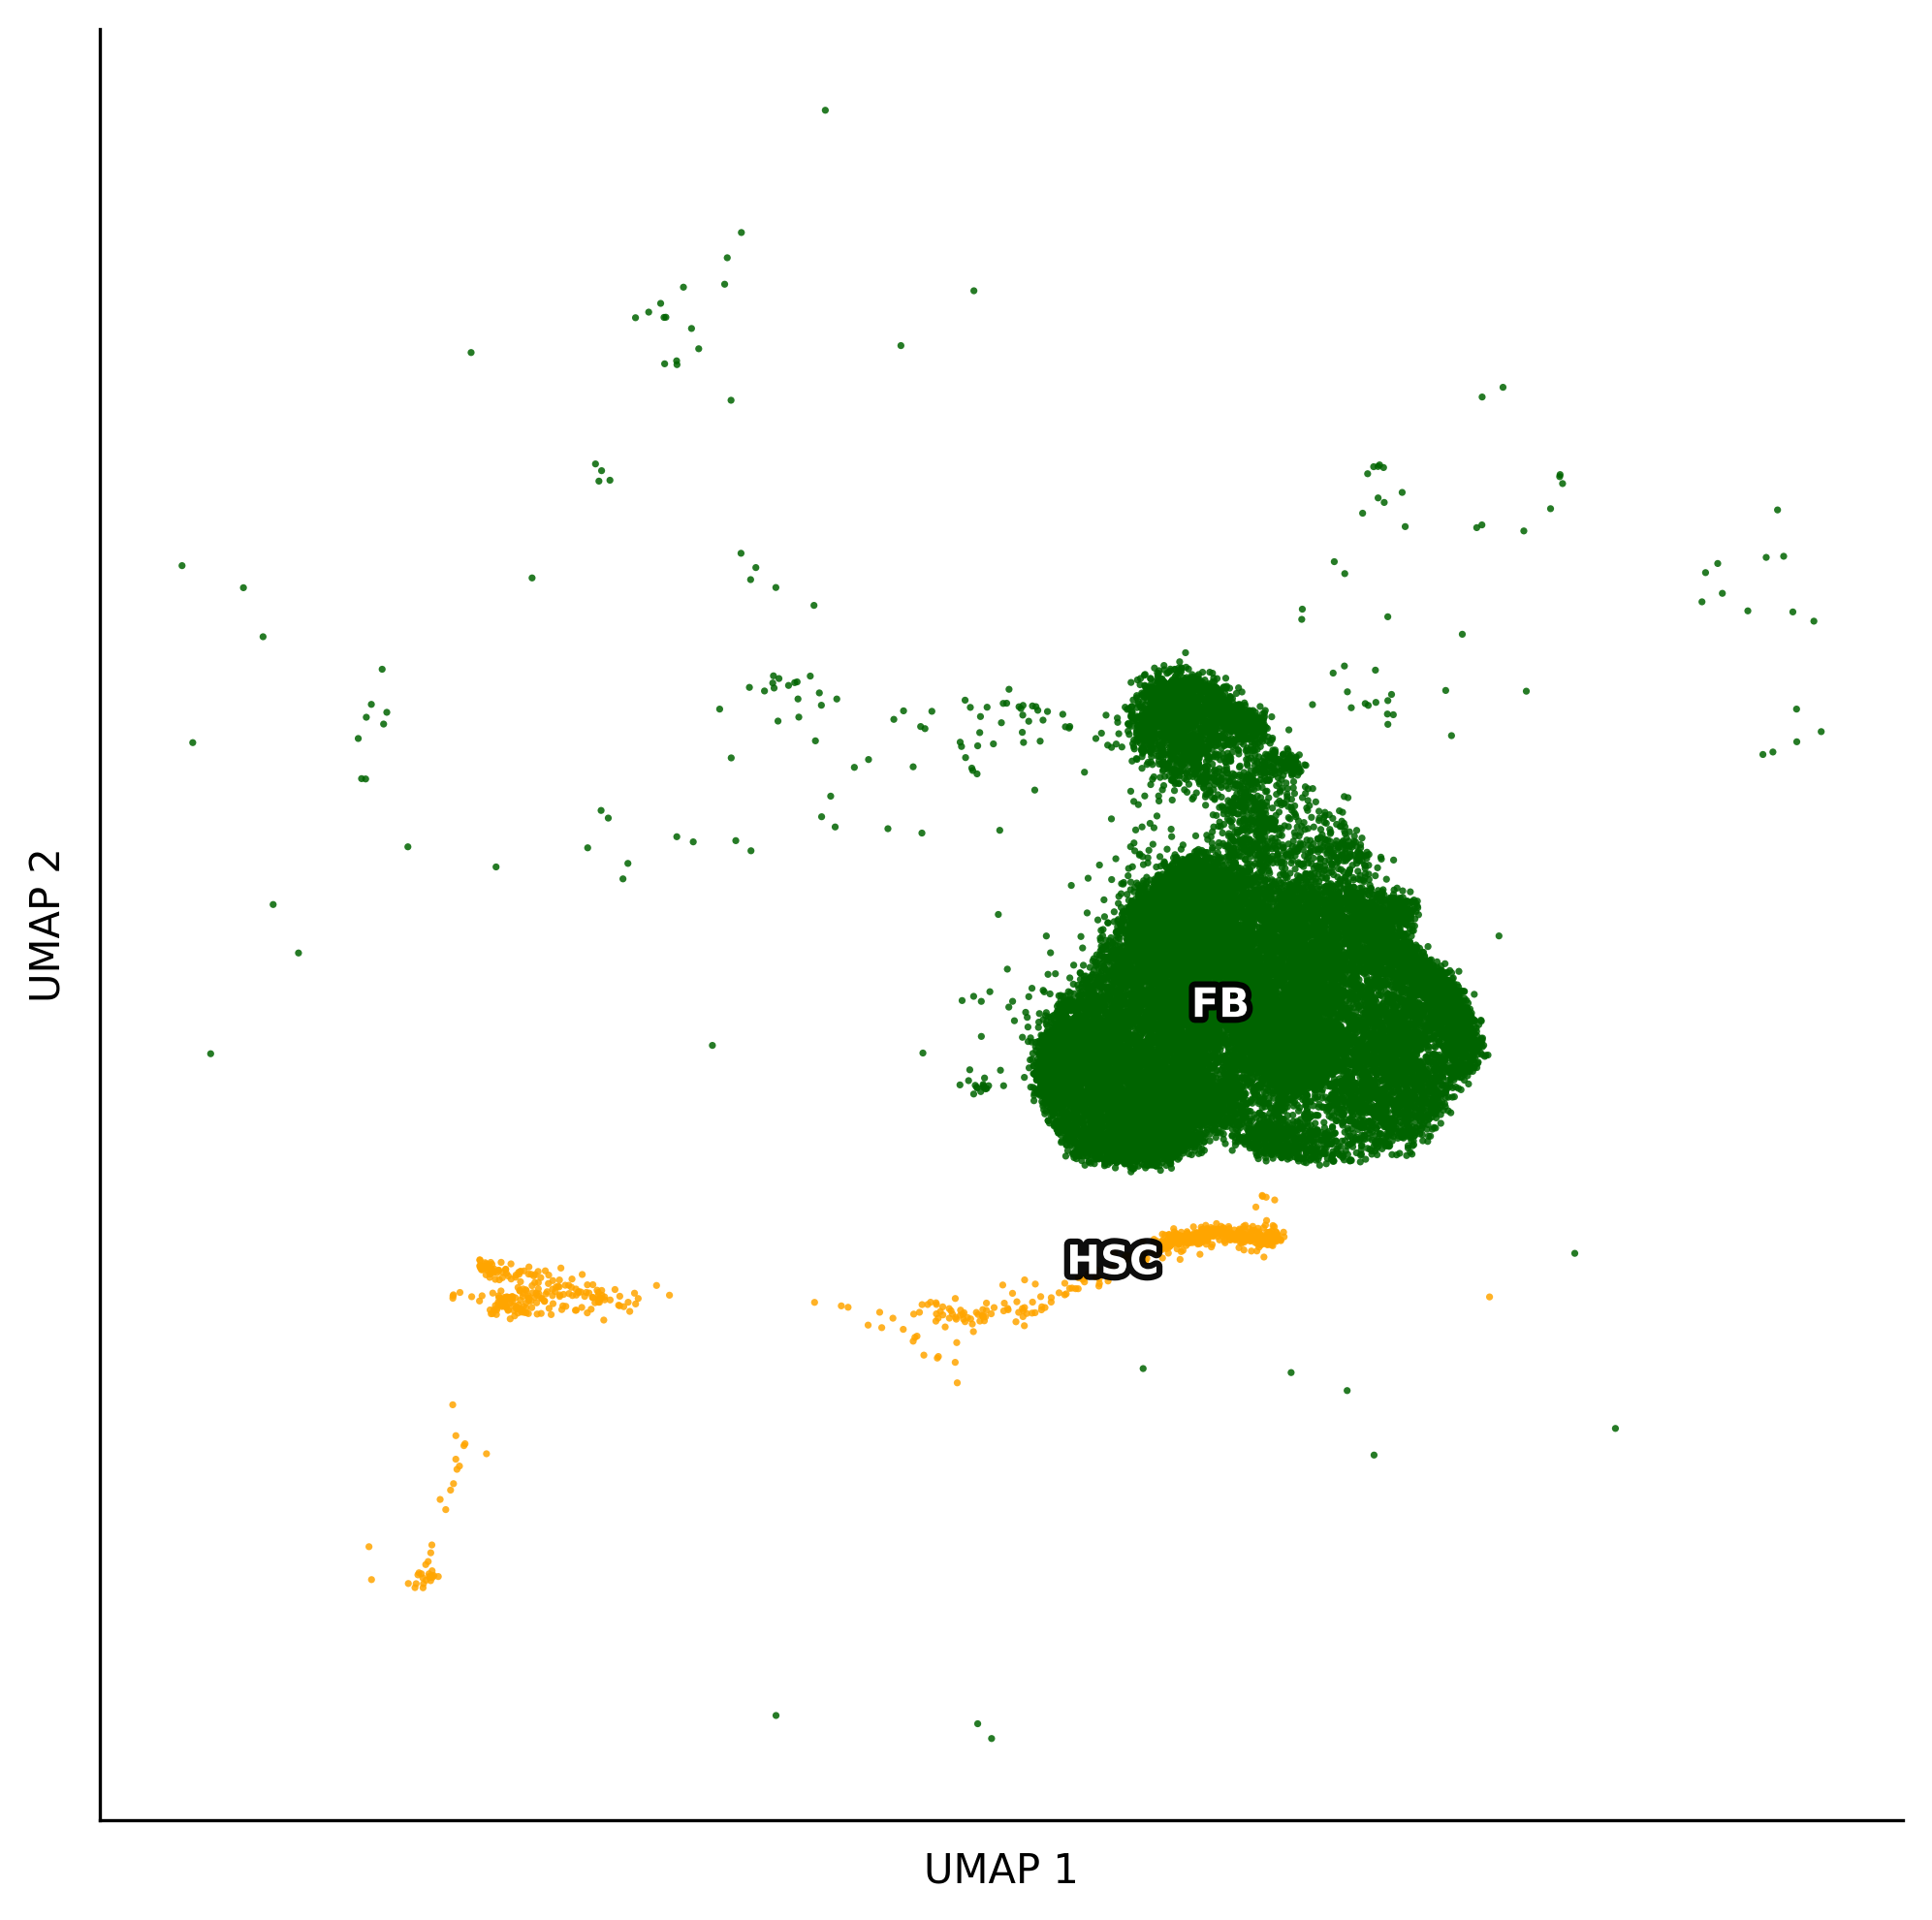

In [13]:
""" UMAP PLOT """
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 8

colors = ['darkgreen', "orange",]


sns.scatterplot(data=sdf.obs,
                x='UMAP 1',
                y='UMAP 2',
                hue='celltype',
                palette=colors,
                s=3,
                alpha=0.85,
                ec='none'
        )

sns.despine()
plt.xticks([])
plt.yticks([])

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# label on data
ax = plt.gca()

def label_pos(labels, ax, color='w', fontsize=10,
              fw='bold', highlight="k", highlight_weight=3):
    """A function to add labels to each cluster """
    for idx, label_record in labels.iterrows():
        ax.text(
            label_record['UMAP 1'],
            label_record['UMAP 2'],
            label_record['label'],
            path_effects=[pe.withStroke(linewidth=highlight_weight, 
                                        foreground=highlight, 
                                        alpha=0.95,)],
            weight=fw,
            color=color,
            verticalalignment="center",
            horizontalalignment="center",
            fontsize=fontsize,
        )

all_pos = sdf.obs.groupby('celltype')[['UMAP 1', 'UMAP 2']].median().reset_index()
all_pos.columns = ['label', 'UMAP 1', 'UMAP 2']

label_pos(all_pos, ax)

plt.gca().legend().remove()

sns.despine()

In [14]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/anndata.clustered.h5ad"

adata = sc.read(fpath, cache=False)
adata.obs['cluster_name'] = adata.obs['clusters'].apply(lambda x: f"C{int(x) + 1}")
adata

/home/cstansbu/.local/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 8484 × 14936
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'clusters', 'cluster_name', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cluster_name_colors', 'clusters_sizes', 'hvg', 'leiden', 'log1p', 'neighbors', 'paga', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

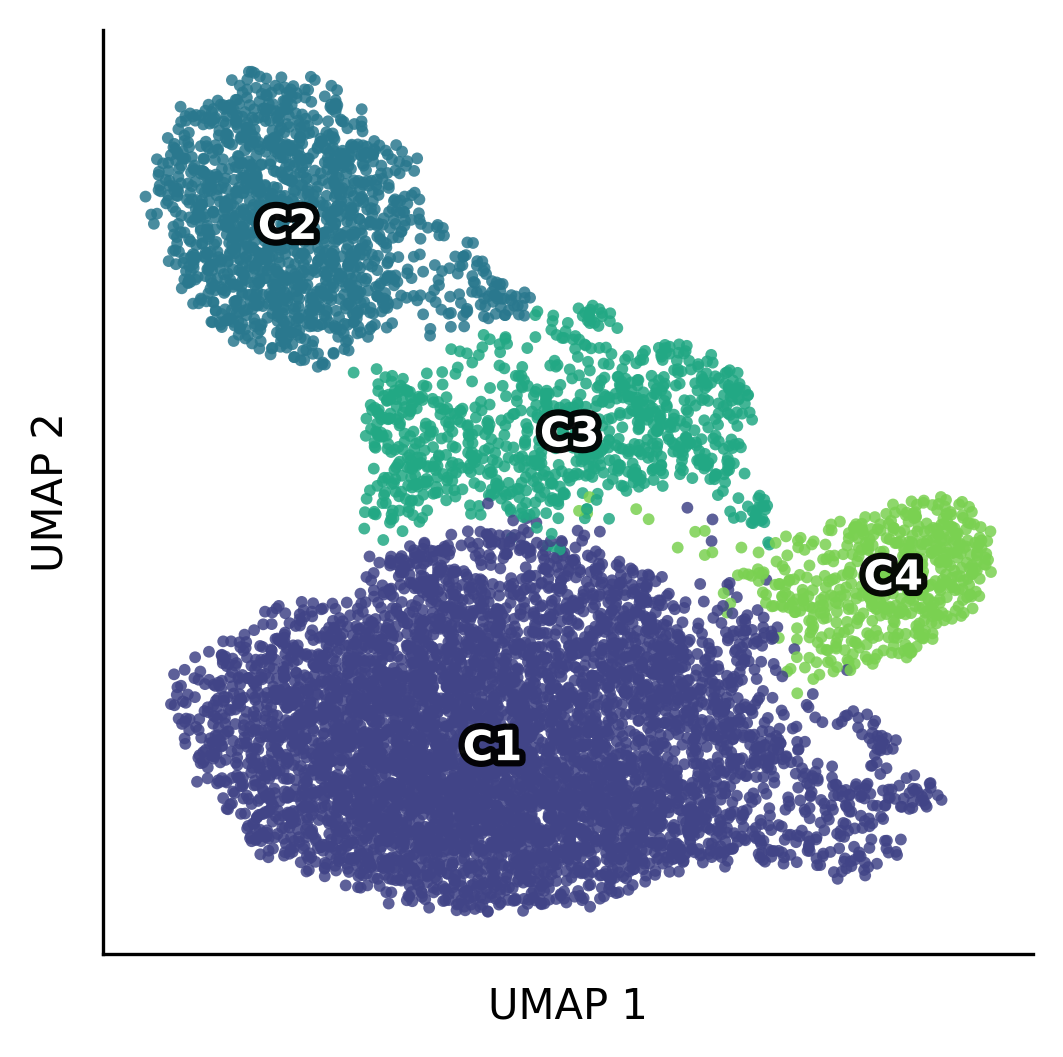

In [16]:
""" UMAP PLOT """
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

colors = ['darkgreen', 'red', "orange", "limegreen"]

sns.scatterplot(data=adata.obs,
                x='UMAP 1',
                y='UMAP 2',
                hue='cluster_name',
                palette='viridis',
                s=8,
                alpha=0.85,
                ec='none'
        )

sns.despine()
plt.xticks([])
plt.yticks([])

plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")

# label on data
ax = plt.gca()

def label_pos(labels, ax, color='w', fontsize=10,
              fw='bold', highlight="k", highlight_weight=3):
    """A function to add labels to each cluster """
    for idx, label_record in labels.iterrows():
        ax.text(
            label_record['UMAP 1'],
            label_record['UMAP 2'],
            label_record['label'],
            path_effects=[pe.withStroke(linewidth=highlight_weight, 
                                        foreground=highlight, 
                                        alpha=0.95,)],
            weight=fw,
            color=color,
            verticalalignment="center",
            horizontalalignment="center",
            fontsize=fontsize,
        )

all_pos = adata.obs.groupby('cluster_name')[['UMAP 1', 'UMAP 2']].median().reset_index()
all_pos.columns = ['label', 'UMAP 1', 'UMAP 2']

label_pos(all_pos, ax)

plt.gca().legend().remove()

sns.despine()